# Install, Paths and Parameters

In [8]:
# This extension reloads external Python files
import os
from pathlib import Path
import getpass
import numpy as np
import pandas as pd
import time
import math
from collections import defaultdict

import torch
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm
import random
import sys
from torch.utils.data import random_split
from matplotlib import pyplot as plt

# allow imports when running script from within project dir
[sys.path.append(i) for i in ['.', '..']]

# local
from src.helpers.helpers import get_random_indexes, get_random_classes
from src.model.dino_model import get_dino
from src.model.train import *
from src.model.data import *

# seed
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

username = getpass.getuser()
DATA_PATH = Path('/','cluster', 'scratch', 'thobauma', 'dl_data')
MAX_PATH = Path('/','cluster', 'scratch', 'mmathys', 'dl_data')
# Path for intermediate outputs
BASE_POSTHOC_PATH = Path(MAX_PATH, 'posthoc-fixed-labels/')
#BASE_POSTHOC_PATH = Path(MAX_PATH, 'posthoc-subset/')
POSTHOC_MODELS_PATH = Path(MAX_PATH,'posthoc-models')

# Original Dataset
ORI_PATH = Path(DATA_PATH, 'ori_data/')
CLASS_SUBSET_PATH = Path(ORI_PATH, 'class_subset.npy')

TR_PATH = Path(ORI_PATH, 'train/')
TR_ORI_LABEL_PATH = Path(TR_PATH,'correct_labels.txt')
TR_ORI_IMAGES_PATH = Path(TR_PATH,'images')

VAL_PATH = Path(ORI_PATH, 'validation/')
VAL_ORI_LABEL_PATH = Path(VAL_PATH,'correct_labels.txt')
VAL_ORI_IMAGES_PATH = Path(VAL_PATH,'images')

# DAmageNet
DN_PATH = Path(DATA_PATH, 'damageNet')
DN_LABEL_PATH = Path(DN_PATH, 'val_damagenet.txt')
DN_IMAGES_PATH = Path(DN_PATH, 'images')
DN_POSTHOC_PATH = Path(BASE_POSTHOC_PATH, 'damagenet')
DN_POSTHOC_LABEL_PATH = Path(DN_POSTHOC_PATH, 'labels.csv')

# PGD
TR_PGD_PATH = Path(MAX_PATH, 'adversarial_data/pgd_06/train')
TR_PGD_LABEL_PATH = TR_ORI_LABEL_PATH
TR_PGD_IMAGES_PATH = Path(TR_PGD_PATH, 'images')
TR_PGD_POSTHOC_PATH = Path(BASE_POSTHOC_PATH, 'pgd/train/')
TR_PGD_POSTHOC_LABEL_PATH = Path(TR_PGD_POSTHOC_PATH, 'labels.csv')

VAL_PGD_PATH = Path(MAX_PATH, 'adversarial_data/pgd_06/validation')
VAL_PGD_LABEL_PATH = VAL_ORI_LABEL_PATH
VAL_PGD_IMAGES_PATH = Path(VAL_PGD_PATH, 'images')
VAL_PGD_POSTHOC_PATH = Path(BASE_POSTHOC_PATH, 'pgd/validation/')
VAL_PGD_POSTHOC_LABEL_PATH = Path(VAL_PGD_POSTHOC_PATH, 'labels.csv')

# CW
TR_CW_PATH = Path(MAX_PATH, 'adversarial_data/cw/train')
TR_CW_LABEL_PATH = TR_ORI_LABEL_PATH
TR_CW_IMAGES_PATH = Path(TR_CW_PATH, 'images')
TR_CW_POSTHOC_PATH = Path(BASE_POSTHOC_PATH, 'cw/train/')
TR_CW_POSTHOC_LABEL_PATH = Path(TR_CW_POSTHOC_PATH, 'labels.csv')

VAL_CW_PATH = Path(MAX_PATH, 'adversarial_data/cw/validation')
VAL_CW_LABEL_PATH = VAL_ORI_LABEL_PATH
VAL_CW_IMAGES_PATH = Path(VAL_CW_PATH, 'images')
VAL_CW_POSTHOC_PATH = Path(BASE_POSTHOC_PATH, 'cw/validation/')
VAL_CW_POSTHOC_LABEL_PATH = Path(VAL_CW_POSTHOC_PATH, 'labels.csv')

# FGSM
TR_FGSM_PATH = Path(MAX_PATH, 'adversarial_data/fgsm_06/train')
TR_FGSM_LABEL_PATH = TR_ORI_LABEL_PATH
TR_FGSM_IMAGES_PATH = Path(TR_FGSM_PATH, 'images')
TR_FGSM_POSTHOC_PATH = Path(BASE_POSTHOC_PATH, 'fgsm/train/')
TR_FGSM_POSTHOC_LABEL_PATH = Path(TR_FGSM_POSTHOC_PATH, 'labels.csv')

VAL_FGSM_PATH = Path(MAX_PATH, 'adversarial_data/fgsm_06/validation')
VAL_FGSM_LABEL_PATH = VAL_ORI_LABEL_PATH
VAL_FGSM_IMAGES_PATH = Path(VAL_FGSM_PATH, 'images')
VAL_FGSM_POSTHOC_PATH = Path(BASE_POSTHOC_PATH, 'fgsm/validation/')
VAL_FGSM_POSTHOC_LABEL_PATH = Path(VAL_FGSM_POSTHOC_PATH, 'labels.csv')

In [9]:
# If CLASS_SUBSET is specified, INDEX_SUBSET will be ignored. Set CLASS_SUBSET=None if you want to use indexes.
# INDEX_SUBSET = get_random_indexes(number_of_images = 50000, n_samples=1000)
# CLASS_SUBSET = get_random_classes(number_of_classes = 25, min_rand_class = 1, max_rand_class = 1001)


CLASS_SUBSET = np.load(CLASS_SUBSET_PATH)

INDEX_SUBSET = None
NUM_WORKERS= 0
PIN_MEMORY=True
EPOCHS = 3
BATCH_SIZE = 256

DEVICE = 'cuda'

In [10]:
datasets_paths = {
            'cw':{ 
                'b':{
                    'train':{
                        'label':TR_ORI_LABEL_PATH,
                        'images':TR_CW_IMAGES_PATH
                    },
                    'val':
                    {
                        'label':VAL_ORI_LABEL_PATH,
                        'images':VAL_CW_IMAGES_PATH
                    }
                }
            },
            'ori':{
                'b':{
                    'train':{
                        'label':TR_ORI_LABEL_PATH,
                        'images':TR_ORI_IMAGES_PATH
                    },
                    'val':{
                        'label':VAL_ORI_LABEL_PATH,
                        'images':VAL_ORI_IMAGES_PATH
                    }
                }
            },
            'dn':{
                'b':{
                    'train':{
                        'label':TR_CW_PATH,
                        'images':None
                    },
                    'val':
                    {
                        'label':VAL_ORI_LABEL_PATH,
                        'images':DN_IMAGES_PATH
                    }
                 }
            },
            'fgsm_06':{
                'b':{
                    'train':{
                        'label':TR_ORI_LABEL_PATH,
                        'images':TR_FGSM_IMAGES_PATH
                    },
                    'val':
                    {
                        'label':VAL_ORI_LABEL_PATH,
                        'images':VAL_FGSM_IMAGES_PATH
                    }
                 }
            },
            'pgd_06':{
                'b':{
                    'train':{
                        'label':TR_ORI_LABEL_PATH,
                        'images':TR_PGD_IMAGES_PATH
                    },
                    'val':
                    {
                        'label':VAL_ORI_LABEL_PATH,
                        'images':VAL_PGD_IMAGES_PATH
                    }
                }
            }
}

datasets = ['ori', 'cw', 'pgd_06', 'fgsm_06']
for ds in datasets:
    ds_dict = datasets_paths[ds]
    ds_dict['p'] = {
        'train': { 
            'images': Path(BASE_POSTHOC_PATH, ds, 'train', 'images'),
            'label': Path(BASE_POSTHOC_PATH, ds, 'train', 'labels.csv')
        },
        'val': { 
            'images': Path(BASE_POSTHOC_PATH, ds, 'val', 'images'),
            'label': Path(BASE_POSTHOC_PATH, ds, 'val', 'labels.csv')
        }
    }
    

In [11]:
adv_datasets = ['cw', 'pgd_06', 'fgsm_06']

train_dfs = {}
for ds in adv_datasets:
    train_dfs[ds] = pd.read_csv(Path(BASE_POSTHOC_PATH, ds, 'train', 'labels_merged.csv'))
    
val_dfs = {}
for ds in adv_datasets:
    val_dfs[ds] = pd.read_csv(Path(BASE_POSTHOC_PATH, ds, 'val', 'labels_merged.csv'))


for name, df in train_dfs.items():
    df=df[df['true_labels']==df['ori_pred']]
    df=df[df['true_labels']!=df[name+'_pred']]
    df =df[['file', 'true_labels', 'ori_pred', name+'_pred']]
    train_dfs[name]=df

In [69]:
class AdvDataset(torch.utils.data.Dataset):
    def __init__(self, or_img_folder, adv_img_folder, index_df):
        super().__init__()
        self.or_img_folder = or_img_folder
        self.adv_img_folder = adv_img_folder
        self.index_df = index_df
        self.adv_transform = ONLY_NORMALIZE_TRANSFORM
        self.ori_transform = ORIGINAL_TRANSFORM
    def __len__(self):
        return len(self.index_df)*2
    
    def __getitem__(self, index):            
        filename = self.index_df['file'].iloc[index%len(self.index_df)]
      #  filename = filename.split('.')[0]+'.pt'
        if index >= len(self.index_df):
            img = Image.open(Path(self.or_img_folder,filename))
            img = img.convert('RGB')

            payload=self.ori_transform(img)
#            payload = torch.load(Path(self.or_img_folder, filename)).cpu()
            label = 0 #torch.tensor(0, dtype=torch.float32)
        else:
            img = Image.open(Path(self.adv_img_folder,filename))
            img = img.convert('RGB')

            payload=self.adv_transform(img)
#            payload = torch.load(Path(self.adv_img_folder, filename)).cpu()
            label = 1 #torch.tensor(1, dtype=torch.float32)
        return payload, label, filename

In [70]:
# loaders
train_set = AdvDataset(datasets_paths['ori']['b']['train']['images'],datasets_paths['cw']['b']['train']['images'], train_dfs['cw'])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=True)
    

In [71]:
labels_cum = None
true_labels_cum = None
images_cum = None

for i, (images, labels, _) in enumerate(train_loader):
    if i>7: break
    if labels_cum is None:
        labels_cum = labels
        images_cum = images
    else:
        labels_cum = torch.cat([labels_cum, labels])
        images_cum = torch.cat([images_cum, images])

In [72]:
reducer = umap.UMAP(random_state=SEED, n_neighbors = 150, n_components=2, metric='canberra')
combined = images_cum
combined_labels = labels_cum
reducer.fit(combined.numpy())
embedding = reducer.transform(combined.numpy())

ValueError: Found array with dim 4. Estimator expected <= 2.

In [ ]:
plt.rcParams["figure.figsize"] = (10,8)
plt.scatter(embedding[:, 0], embedding[:, 1], c=combined_labels, cmap='Spectral', s=20)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar()

# UMAP

In [50]:
import umap
import matplotlib.pyplot as plt

## Combined

In [54]:
reducer = umap.UMAP(random_state=SEED, n_neighbors = 150, n_components=2, metric='canberra')

In [55]:
combined = images_cum
combined_labels = labels_cum

In [56]:
reducer.fit(combined.numpy())

UMAP(metric='canberra', n_neighbors=150, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [57]:
embedding = reducer.transform(combined.numpy())

In [58]:
#combined_labels = [0]*50 + [1]*50 + [2]*50 + [3]*50

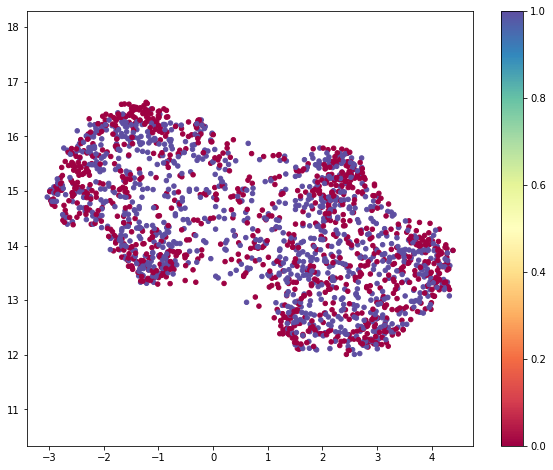

In [59]:
plt.rcParams["figure.figsize"] = (10,8)
plt.scatter(embedding[:, 0], embedding[:, 1], c=combined_labels, cmap='Spectral', s=20)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar()

In [28]:
# Fancy plot
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper, Legend
from bokeh.palettes import Spectral10, Category10
import pandas as pd
from io import BytesIO
from PIL import Image
import base64

output_notebook()

Loading BokehJS ...

In [48]:
df = pd.DataFrame(embedding, columns=('x', 'y'))
df['label'] = [str(x) for x in combined_labels]
#df = pd.read_csv('df.csv', index_col=0)
df['label'] = [str(x) for x in df.label]
df['true_label'] = combined_labels
df['true_label'] = df['true_label'].replace({0: "Class 0 (Orig.)", 1: "Class 1 (Orig.)", 2: "Class 2 (Orig.)", 3: "Class 0 (Adv.)", 4: "Class 1 (Adv.)", 5: "Class 2 (Adv.)"})

datasource = ColumnDataSource(df)
color_mapping = CategoricalColorMapper(factors=[str(6 - x) for x in [i for i in range(6)]],
                                       palette=Category10[6])

plot_figure = figure(
    title='',
    plot_width=600,
    plot_height=400,
    tools=('pan, wheel_zoom, reset, save')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <span style='font-size: 16px; color: #224499'>Label:</span>
        <span style='font-size: 18px'>@true_label</span>
    </div>
</div>
"""))

plot_figure.add_layout(Legend(), 'right')

plot_figure.circle(
    'x',
    'y',
    source=datasource,
    color=dict(field='label', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=6,
    legend_field='true_label'
)

plot_figure.xaxis.visible = False
plot_figure.xgrid.visible = False
plot_figure.yaxis.visible = False
plot_figure.ygrid.visible = False

plot_figure.outline_line_width = 2
plot_figure.outline_line_alpha = 0.8
plot_figure.outline_line_color = "gray"

plot_figure.legend.location = "center"
plot_figure.legend.title = ""
plot_figure.legend.title_text_font_style = "bold"
plot_figure.legend.title_text_font_size = "14px"

show(plot_figure);